# Asymmetric errors

Sherpa provides *minimal* support for asymmetric errors - where the low and high error values do not match. The approach taken is currently designed to work best wih the Astronomy UI interface, so that will be used in this notebook.

In [1]:
from sherpa.astro import ui
from sherpa.utils.testing import get_datadir

For this example we shall use one of the test datasets, which contains `x` and `y` values along with the error range on `y`:

In [2]:
from pathlib import Path
inpath = Path(get_datadir()) / 'gro.txt'

# Display the first 5 lines
with open(inpath) as fh:
    for inval in fh.readlines()[:5]:
        print(inval.strip())

0.00310   13.383   12.379   15.002
0.00284   13.352   12.437   14.323
0.00413   14.717   12.992   15.693
0.00469   14.275   13.518   15.093
0.00451   13.169   12.321   14.319


This can be read in with the `load_ascii_with_errors` command (it can also files where the errors are given as relative values by setting `delta=True` in the call):

In [3]:
ui.load_ascii_with_errors(str(inpath))

Let's change the name field to avoid the full path:

In [4]:
ui.get_data().name = 'gro.txt'

If we display the object we can see there's a `staterror` field as well as `elo` and `ehi`. The `staterror` field is set to be the average of the `elo` and `ehi` fields, which give the low and high errors:

In [5]:
print(ui.get_data())

name      = gro.txt
x         = Float64[61]
y         = Float64[61]
staterror = Float64[61]
syserror  = None
elo       = Float64[61]
ehi       = Float64[61]


If we access the fields we can see how they are related:

In [6]:
d = ui.get_data()

for idx, (err, elo, ehi) in enumerate(zip(d.staterror, d.elo, d.ehi)):
    if idx == 5:
        break
        
    print(f"  {err:.3f}    {elo:.3f} - {ehi:.3f}")

  1.312    1.004 - 1.619
  0.943    0.915 - 0.971
  1.350    1.725 - 0.976
  0.787    0.757 - 0.818
  0.999    0.848 - 1.150


When the data is plotted the asymmetric errors are shown:

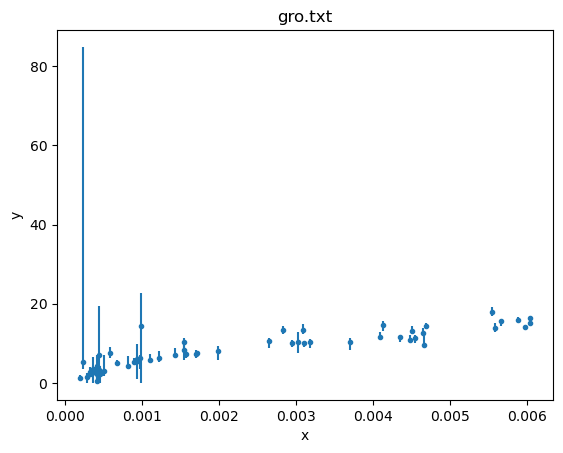

In [7]:
ui.plot_data()

However, the `staterror` field is used when a statistic is needed - e.g. with `calc_stat` or when fitting:

In [8]:
ui.set_stat("chi2")
ui.set_source(ui.powlaw1d.pl)

print(ui.calc_stat())

248263792.37785548


In [9]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 2.48264e+08
Final fit statistic   = 84.7331 at function evaluation 61
Data points           = 61
Degrees of freedom    = 59
Probability [Q-value] = 0.0157157
Reduced statistic     = 1.43615
Change in statistic   = 2.48264e+08
   pl.gamma       -0.598396    +/- 0.0207753   
   pl.ampl        332.533      +/- 38.2647     


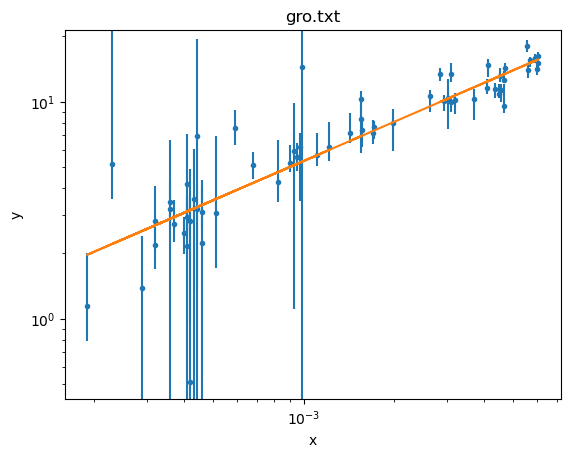

In [10]:
ui.plot_fit(xlog=True, ylog=True)

As with the `fit` call, `covar` and `conf` use the "average" error bar:

In [11]:
ui.conf()

pl.gamma lower bound:	-0.02077
pl.ampl lower bound:	-35.0532
pl.gamma upper bound:	0.0201346
pl.ampl upper bound:	40.4317
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pl.gamma        -0.598396     -0.02077    0.0201346
   pl.ampl           332.533     -35.0532      40.4317


We will use the `confidence` results below, so store them:

In [12]:
conf = ui.get_conf_results()

print(conf)

datasets    = (1,)
methodname  = confidence
iterfitname = none
fitname     = levmar
statname    = chi2
sigma       = 1
percent     = 68.26894921370858
parnames    = ('pl.gamma', 'pl.ampl')
parvals     = (-0.5983957573984634, 332.53266628336416)
parmins     = (-0.020770017510067684, -35.053209709661644)
parmaxes    = (0.020134631729182173, 40.43171458331858)
nfits       = 18


We can draw a vertical rectangle on a plot to show the gamma range (from `parvals + parmins` to `parvals + parmaxes`, since `parmins < 0`). As I plan to use this more-than once I make a helper routine:

In [13]:
from matplotlib import pyplot as plt

def add_conf_gamma():
    """Draw a rectangle representing the gamma conf results on the plot."""

    # Label on the conf result as a rectangle
    ymin, ymax = plt.ylim()
    xy = (conf.parvals[0] + conf.parmins[0], ymin)
    dx = conf.parmaxes[0] - conf.parmins[0]
    dy = ymax - ymin
    patch = plt.Rectangle(xy, dx, dy, color='k', alpha=0.2)
    ax = plt.gca()
    ax.add_patch(patch)

This routine can be used to overplot the `conf` results on a `region-projection` plot, showing that the 1D results (e.g. from `conf`) are slightly smaller than the 2D results (as expected):

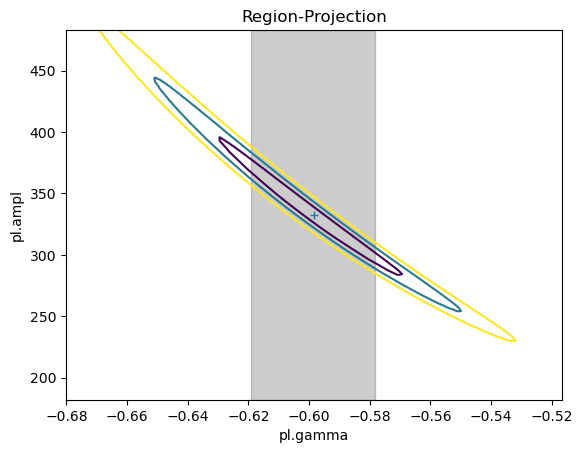

In [14]:
ui.reg_proj(pl.gamma, pl.ampl, nloop=[101, 101])
add_conf_gamma()

So, **all** the above used the average error values when calculating statistic values. The question is, how much different would it be if the fit could use the asymmetric errors?

The `resample_data` call allows us to estimate what the asymmetry means for any error estimation. It performs a parametric bootstrap assuming a skewed normal distribution centered on the observed data point with the variance given by the low and high measurement errors. The function simulates a number of realizations of the data and fits each realization with the assumed model to obtain the best fit parameters. It returns the best fit parameters for each realization, and displays the average and standard deviation for each parameter.

In the following we explicitly ask for 1000 iterations (although that is the default value) and fix the random-number seed.

In [15]:
result = ui.resample_data(niter=1000, seed=123)

pl.gamma : avg = -0.4180195954679258 , std = 0.19844933475231044
pl.ampl : avg = 163.0552687577543 , std = 94.50832743941801


The routine returns a dictionary with arrays as values; we can check what the keys are with:

In [16]:
print(result.keys())

dict_keys(['samples', 'statistic', 'pl.gamma', 'pl.ampl'])


A trace of the statistic value can be created (at present this is always calculated using the least-squares statistic):

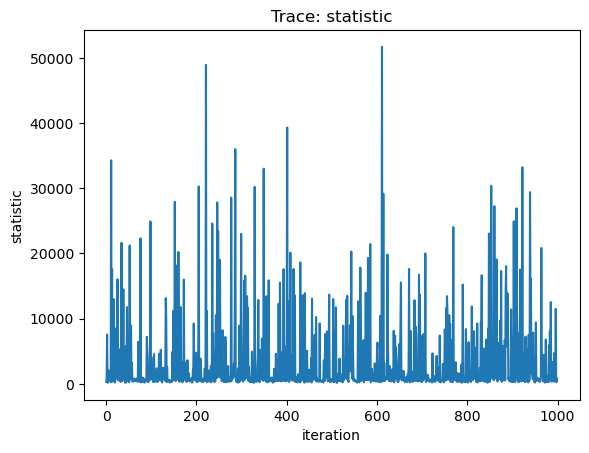

In [17]:
ui.plot_trace(result['statistic'], name='statistic')

The other fields can be displayed, either with Sherpa commands like `plot_trace`, `plot_scatter`, `plot_cdf`, and `plot_pdf`, or directly with a plotting library:

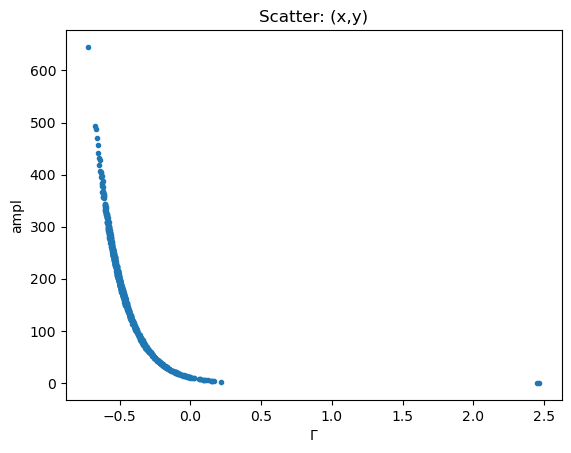

In [18]:
ui.plot_scatter(result['pl.gamma'], result['pl.ampl'], xlabel=r'$\Gamma$', ylabel='ampl')

We can compare the fit result from earlier to that from the resampled data. In this particular case we can see that the `conf` result (the gray band) is both 

- too narrow
- and biased

due to the assumption of symmetric errors.

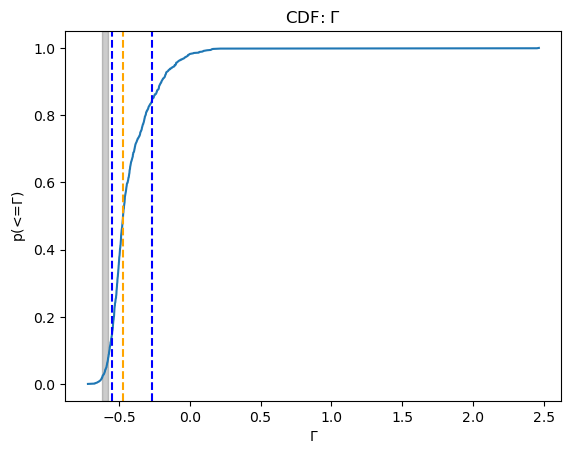

In [19]:
ui.plot_cdf(result['pl.gamma'], xlabel=r'$\Gamma$', name=r'$\Gamma$')
add_conf_gamma()

We can use the parameter distribution to estimate errors. Sherpa has useful routines for this but other modules - such as NumPy - can be used. Here we use the `get_error_estimates` routine to return the median value along with the 1-sigma range calculated from the input distribution:

In [20]:
from sherpa.utils import get_error_estimates

mval, lval, uval = get_error_estimates(result['pl.gamma'])
print(f"median = {mval:.3f}")
print(f" range = {lval:.3f} - {uval:.3f}") 

median = -0.472
 range = -0.547 - -0.269


Or use `quantile` to select a non-standard range:

In [21]:
from sherpa.utils import quantile

print(quantile(result['pl.gamma'], 0.05))
print(quantile(result['pl.gamma'], 0.95))

-0.5890799324170864
-0.10309411994420781
